In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install wandb
! pip install -U accelerate
! pip install -U transformers

!pip install transformers[torch]
!pip install accelerate = 0.20.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 31.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
ERROR: Invalid requirement: '='
Hint: = is not a valid operator. Did you mean == ?


In [3]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.36.2', '0.25.0')

In [4]:
import pandas as pd
import numpy as np
import transformers
from transformers import (
    XLNetTokenizerFast,
    XLNetForSequenceClassification,
    AlbertTokenizerFast,
    AlbertForSequenceClassification,

    RobertaTokenizerFast,
    RobertaForSequenceClassification,

    BertTokenizerFast,
    BertForSequenceClassification,

    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,

    Trainer,
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from transformers import EarlyStoppingCallback
import torch

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [6]:
def compute_metrics(p):
    pred, labels = p

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(y_true=labels, y_score=pred)

    return {"auc_roc": auc_roc}

#Transformer의 작동 방식 확인

In [7]:
# Load the tokenizer
from transformers import BertTokenizer, LineByLineTextDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
# Define pretrained tokenizer and model
model_name = "bert-base-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model_bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
text = 'Hello how are you I am Yeoneung Kim'

In [12]:
t = tokenizer.encode(text, add_special_tokens=True)

In [13]:
import numpy as np

def positional_encoding_text(text, d_model):
    # Split the text into individual words
    words = text.split()

    # Get the maximum length of the sequence
    max_len = len(words)

    # Generate positional encoding matrix
    position = np.arange(max_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((max_len, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)

    return pe

def print_positional_encoding(pe_matrix):
    for row in pe_matrix:
        print(" ".join(f"{val:.2f}" for val in row))

# Example usage
text = 'Hello how are you I am Yeoneung Kim'
d_model = 10  # Adjust the model dimension as needed
pos_encoding_text = positional_encoding_text(text, d_model)

# Print the positional encoding matrix for the given text
print_positional_encoding(pos_encoding_text)

0.00 1.00 0.00 1.00 0.00 1.00 0.00 1.00 0.00 1.00
0.84 0.54 0.16 0.99 0.03 1.00 0.00 1.00 0.00 1.00
0.91 -0.42 0.31 0.95 0.05 1.00 0.01 1.00 0.00 1.00
0.14 -0.99 0.46 0.89 0.08 1.00 0.01 1.00 0.00 1.00
-0.76 -0.65 0.59 0.81 0.10 0.99 0.02 1.00 0.00 1.00
-0.96 0.28 0.71 0.70 0.13 0.99 0.02 1.00 0.00 1.00
-0.28 0.96 0.81 0.58 0.15 0.99 0.02 1.00 0.00 1.00
0.66 0.75 0.90 0.45 0.17 0.98 0.03 1.00 0.00 1.00


#모델 Parameter수 확인

In [10]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
print_trainable_parameters(model_bert)

trainable params: 108311041 || all params: 108311041 || trainable%: 100.0


#DistilBert

In [14]:
train_data = pd.read_csv("/content/drive/MyDrive/llm2/train_drcat_04.csv")
test_data = pd.read_csv("/content/drive/MyDrive/llm-detect-ai-generated-text/test_essays.csv")
chat = pd.read_excel('/content/drive/MyDrive/llm-detect-ai-generated-text/Chat+Bard.xlsx')
train = pd.read_csv('/content/drive/MyDrive/llm-detect-ai-generated-text/train_essays.csv')

In [15]:
#Custom dataset
chat2 = chat[["text", "label"]]

train2 = train[['text', 'generated']].head(18)
train2.rename(columns = {'generated' : 'label'}, inplace=True)

merged_df = pd.concat([chat2, train2], ignore_index=True)

# 결과 확인
merged_df.head()
print(len(merged_df))

36


In [ ]:
#Wandb에 저장
import wandb
wandb.init(project='LLM2')

# 실행 이름 설정
wandb.run.name = 'DistilBert3'
wandb.run.save()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define pretrained tokenizer and model
model_name = "distilbert-base-cased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
tokenizer.save_pretrained('/content/DistilBert')
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=1)

# ----- 1. Preprocess data -----#
# Preprocess data
X = list(train_data["text"])
y = list(train_data["label"])
X_test = list(test_data["text"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
y_train = [float(label) for label in y_train]
y_val = [float(label) for label in y_val]

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    #report_to="wandb",  # enable logging to W&B
    run_name="distilbert-base-openai-detector(fixed)",  # name of the W&B run (optional)
    logging_steps=1
)


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


# Train pre-trained model
trainer.train()

In [ ]:
model_save_path = "content/checkpoint-1"
trainer.save_model(model_save_path)

config_save_path = "content/checkpoint-1"
model.config.save_pretrained(config_save_path)

In [ ]:
model_save_path = "/content/drive/MyDrive/LLM Parameter/distillbert_model"
trainer.save_model(model_save_path)

#config_save_path = "/content/drive/MyDrive/LLM Parameter"
#model.config.save_pretrained(config_save_path)

In [ ]:
!zip -r /content/Distilbert_model.zip /content/content/checkpoint-1

	zip warning: name not matched: Parameter/distill_bert_model.zip


zip error: Interrupted (aborting)


In [ ]:
!zip -r /content/Distilbert_token2.zip /content/DistilBert

  adding: content/DistilBert/ (stored 0%)
  adding: content/DistilBert/tokenizer.json (deflated 70%)
  adding: content/DistilBert/vocab.txt (deflated 49%)
  adding: content/DistilBert/special_tokens_map.json (deflated 42%)
  adding: content/DistilBert/tokenizer_config.json (deflated 76%)


#모델 예측

In [ ]:
import torch.nn.functional as F

X_test = list(test_data["text"])

#tokenizer = DistilBertTokenizerFast.from_pretrained("/content/drive/MyDrive/LLM Parameter/Distilbert/distilbert/model.safetensors")
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model
#model_path = "/content/drive/MyDrive/LLM Parameter/Distilbert/distilbert/model.safetensors"
#model =DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=1)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

test_pred = (torch.tensor(raw_pred)).numpy().ravel()
print(test_pred)

[0.01876952 0.01453518 0.01487168]


#Bert

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

df = pd.read_csv("/content/drive/MyDrive/llm2/train_drcat_04.csv")
# Define pretrained tokenizer and model
model_name = "bert-base-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model_bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# Define pretrained tokenizer and model
model_name = "bert-base-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model_bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)

# ----- 1. Preprocess data -----#
# Preprocess data
X = list(train_data["text"])
y = list(train_data["label"])
X_test = list(test_data["text"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
y_train = [float(label) for label in y_train]
y_val = [float(label) for label in y_val]

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    report_to="wandb",  # enable logging to W&B
    run_name="bert-base-openai-detector(fixed)",  # name of the W&B run (optional)
    logging_steps=1
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train pre-trained model
trainer.train()

Custom Dataset 예측

In [ ]:
import zipfile
import os

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/Bert/fine_tuned_tokenizer.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/Bert/fine_tuned_model.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("/content/content/fine_tuned_Token")
Chat_test = list(merged_df["text"])

# Tokenize the test data
chat_test_tokenized = tokenizer(Chat_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
chat_test_dataset = Dataset(chat_test_tokenized)

# Load the trained model using AutoModelForSequenceClassification
model_path = "/content/content/fine_tuned_model"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=1, ignore_mismatched_sizes=True)

# Define the test trainer
test_trainer = Trainer(model)

# Make predictions
raw_pred = test_trainer.predict(chat_test_dataset).predictions

# Apply sigmoid activation if necessary
test_pred1 = (torch.tensor(raw_pred)).numpy().ravel()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/content/fine_tuned_model and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROC AUC test: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


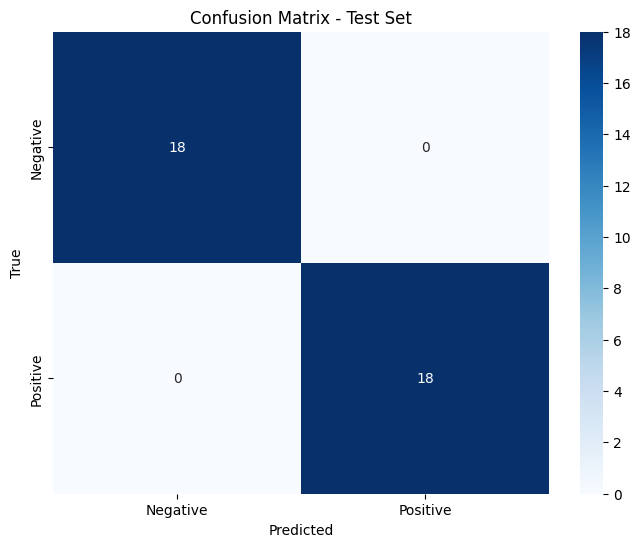

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
preds_test = test_pred1
y_test_vectors = merged_df['label']

# Generate confusion matrix
fpr, tpr, thresholds = roc_curve(y_test_vectors, preds_test)
roc_auc = auc(fpr, tpr)

# You can choose a threshold based on your requirements, for example, maximizing the F1 score
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Convert probabilities to binary predictions using the optimal threshold
binary_preds_test = (preds_test >= optimal_threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_vectors, binary_preds_test)

# Calculate additional metrics
accuracy = accuracy_score(y_test_vectors, binary_preds_test)
precision = precision_score(y_test_vectors, binary_preds_test)
recall = recall_score(y_test_vectors, binary_preds_test)
f1 = f1_score(y_test_vectors, binary_preds_test)

# Print metrics
print('ROC AUC test:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

#XLnet_train

In [ ]:
import wandb
wandb.init(project='LLM')

# 실행 이름 설정
wandb.run.name = 'XLnet'
wandb.run.save()

wandb: Currently logged in as: iuapink0522. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [ ]:
# Define pretrained tokenizer and model
model_name = "xlnet-base-cased"
tokenizer =  XLNetTokenizerFast.from_pretrained(model_name)
model_xlnet = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=1)

# ----- 1. Preprocess data -----#
# Preprocess data
X = list(train_data["text"])
y = list(train_data["label"])
X_test = list(test_data["text"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
y_train = [float(label) for label in y_train]
y_val = [float(label) for label in y_val]

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    report_to="wandb",  # enable logging to W&B
    run_name="xlnet-base-openai-detector(fixed)",  # name of the W&B run (optional)
    logging_steps=1
)

trainer = Trainer(
    model=model_xlnet,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train pre-trained model
trainer.train()

In [ ]:
model_save_path = "/content/drive/MyDrive/LLM Parameter/xlnet"
trainer.save_model(model_save_path)

config_save_path = '/content/drive/MyDrive/LLM Parameter/xlnet'
model.config.save_pretrained(config_save_path)

custom dataset

In [ ]:
import zipfile
import os

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/XLnet.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
tokenizer = XLNetTokenizerFast.from_pretrained("/content/file_tokenizer_4/content/xlnet_1")
Chat_test = list(merged_df["text"])

# Tokenize the test data
chat_test_tokenized = tokenizer(Chat_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
chat_test_dataset = Dataset(chat_test_tokenized)

# Load the trained model using AutoModelForSequenceClassification
model_path = "/content/file_4/content/output/checkpoint-2500"
model = XLNetForSequenceClassification.from_pretrained(model_path, num_labels=1, ignore_mismatched_sizes=True)

# Define the test trainer
test_trainer = Trainer(model)

# Make predictions
raw_pred = test_trainer.predict(chat_test_dataset).predictions

# Apply sigmoid activation if necessary
test_pred2 = (torch.tensor(raw_pred)).numpy().ravel()

ROC AUC test: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


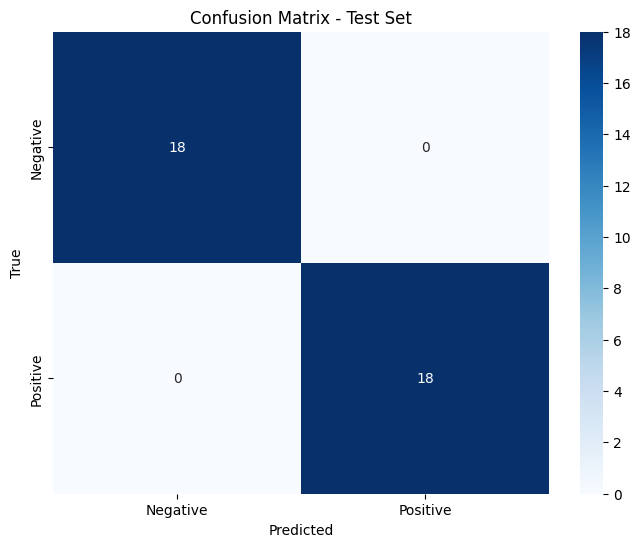

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
preds_test = test_pred2
y_test_vectors = merged_df['label']

# Generate confusion matrix
fpr, tpr, thresholds = roc_curve(y_test_vectors, preds_test)
roc_auc = auc(fpr, tpr)

# You can choose a threshold based on your requirements, for example, maximizing the F1 score
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Convert probabilities to binary predictions using the optimal threshold
binary_preds_test = (preds_test >= optimal_threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_vectors, binary_preds_test)

# Calculate additional metrics
accuracy = accuracy_score(y_test_vectors, binary_preds_test)
precision = precision_score(y_test_vectors, binary_preds_test)
recall = recall_score(y_test_vectors, binary_preds_test)
f1 = f1_score(y_test_vectors, binary_preds_test)

# Print metrics
print('ROC AUC test:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

#Albert_train

In [ ]:
# Define pretrained tokenizer and model
model_name = "aibert-base-cased"
tokenizer =  AlbertTokenizerFast.from_pretrained(model_name)
model_aibert = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=1)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# ----- 1. Preprocess data -----#
# Preprocess data
X = list(train_data["text"])
y = list(train_data["label"])
X_test = list(test_data["text"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
y_train = [float(label) for label in y_train]
y_val = [float(label) for label in y_val]

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized)

In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    report_to="wandb",  # enable logging to W&B
    run_name="aibert-base-cased-openai-detector(fixed)",  # name of the W&B run (optional)
    logging_steps=1
)
trainer = Trainer(
    model=model_aibert,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train pre-trained model
trainer.train()

In [ ]:
model_save_path = "/content/drive/MyDrive/LLM Parameter/AIbert"
trainer.save_model(model_save_path)

config_save_path = '/content/drive/MyDrive/LLM Parameter/AIbert'
model.config.save_pretrained(config_save_path)

custom dataset

In [ ]:
import zipfile
import os

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/albert.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
tokenizer = AlbertTokenizerFast.from_pretrained("/content/file_tokenizer_2/content/albert_1")
Chat_test = list(merged_df["text"])

# Tokenize the test data
chat_test_tokenized = tokenizer(Chat_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
chat_test_dataset = Dataset(chat_test_tokenized)

# Load the trained model using AutoModelForSequenceClassification
model_path = "/content/file_3/content/output/checkpoint-10500"
model = AlbertForSequenceClassification.from_pretrained(model_path, num_labels=1, ignore_mismatched_sizes=True)

# Define the test trainer
test_trainer = Trainer(model)

# Make predictions
raw_pred = test_trainer.predict(chat_test_dataset).predictions

# Apply sigmoid activation if necessary
test_pred3 = (torch.tensor(raw_pred)).numpy().ravel()

ROC AUC test: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


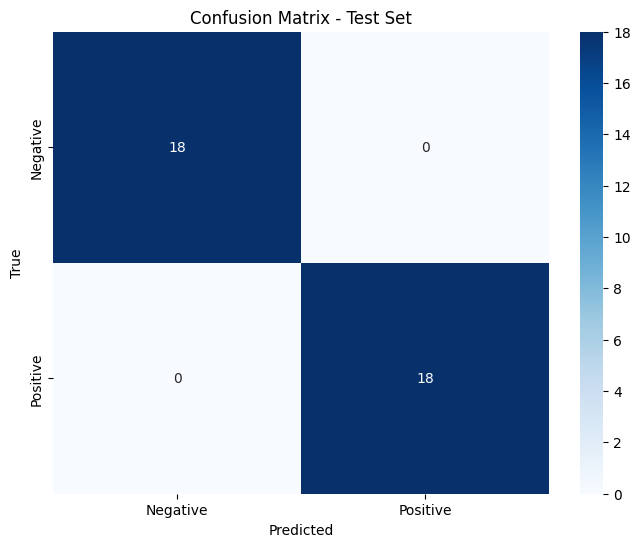

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
preds_test = test_pred3
y_test_vectors = merged_df['label']

# Generate confusion matrix
fpr, tpr, thresholds = roc_curve(y_test_vectors, preds_test)
roc_auc = auc(fpr, tpr)

# You can choose a threshold based on your requirements, for example, maximizing the F1 score
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Convert probabilities to binary predictions using the optimal threshold
binary_preds_test = (preds_test >= optimal_threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_vectors, binary_preds_test)

# Calculate additional metrics
accuracy = accuracy_score(y_test_vectors, binary_preds_test)
precision = precision_score(y_test_vectors, binary_preds_test)
recall = recall_score(y_test_vectors, binary_preds_test)
f1 = f1_score(y_test_vectors, binary_preds_test)

# Print metrics
print('ROC AUC test:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

#Roberta_train

In [ ]:
# Define pretrained tokenizer and model
model_name = "roberta-base-cased"
tokenizer =  RobertaTokenizerFast.from_pretrained(model_name)
robert = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=1)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# ----- 1. Preprocess data -----#
# Preprocess data
X = list(train_data["text"])
y = list(train_data["label"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized)

In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    report_to="wandb",  # enable logging to W&B
    run_name="aibert-base-cased-openai-detector(fixed)",  # name of the W&B run (optional)
    logging_steps=1
)
trainer = Trainer(
    model=model_roberta,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train pre-trained model
trainer.train()

In [ ]:
model_save_path = "/content/drive/MyDrive/LLM Parameter/AIbert"
trainer.save_model(model_save_path)

config_save_path = '/content/drive/MyDrive/LLM Parameter/AIbert'
model.config.save_pretrained(config_save_path)

In [ ]:
import zipfile
import os

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/robert.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("/content/roberta_1")
Chat_test = list(merged_df["text"])

# Tokenize the test data
chat_test_tokenized = tokenizer(Chat_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
chat_test_dataset = Dataset(chat_test_tokenized)

# Load the trained model using AutoModelForSequenceClassification
model_path = "/content/file_2/content/output/checkpoint-3000"
model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=1, ignore_mismatched_sizes=True)

# Define the test trainer
test_trainer = Trainer(model)

# Make predictions
raw_pred = test_trainer.predict(chat_test_dataset).predictions

# Apply sigmoid activation if necessary
test_pred4 = (torch.tensor(raw_pred)).numpy().ravel()

ROC AUC test: 0.9753086419753086
Accuracy: 0.9444444444444444
Precision: 1.0
Recall: 0.8888888888888888
F1 Score: 0.9411764705882353


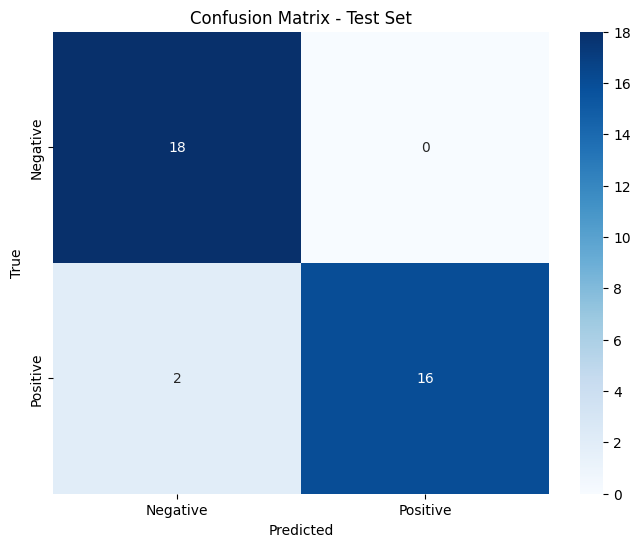

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
preds_tes = test_pred4
y_test_vectors = merged_df['label']

# Generate confusion matrix
fpr, tpr, thresholds = roc_curve(y_test_vectors, preds_test)
roc_auc = auc(fpr, tpr)

# You can choose a threshold based on your requirements, for example, maximizing the F1 score
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Convert probabilities to binary predictions using the optimal threshold
binary_preds_test = (preds_test >= optimal_threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_vectors, binary_preds_test)

# Calculate additional metrics
accuracy = accuracy_score(y_test_vectors, binary_preds_test)
precision = precision_score(y_test_vectors, binary_preds_test)
recall = recall_score(y_test_vectors, binary_preds_test)
f1 = f1_score(y_test_vectors, binary_preds_test)

# Print metrics
print('ROC AUC test:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()